In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

In [20]:
# Download Tarland data into a Pandas dataframe
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm per day
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True) 

In [21]:
# DEFINE ODE SYSTEM AS A FUNCTION

from scipy.integrate import odeint

def f(y, t, params):
    """ Define ODE system.
            y is list [Vs, Qs, Qg, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, f_IExcess, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vs_i = y[0]
    Qs_i = y[1]
    Qg_i = y[2]
    
    # Unpack params
    P, E, f_IExcess, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    ##dQq_dt = (f_IExcess*P - Qq_i)/T_q
    dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2))) + (1/(T_s*(np.exp(fc-Vs_i) + 1)))
    dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
    dQs_dt = dQs_dV*dVs_dt
    dQg_dt = (beta*Qs_i - Qg_i)/T_g
    dDs_dt = (1 - beta)*Qs_i
    dDg_dt = Qg_i
    
    # Add results of equations to an array
    res = np.array([dVs_dt, dQs_dt, dQg_dt, dDs_dt, dDg_dt])
    
    return res

                    Vs        Qs        Qg          Ds          Dg
298.798799  332.039182  4.203918  2.258134  380.289641  344.621021
299.099099  332.039182  4.203918  2.258927  380.794617  345.299258
299.399399  332.039182  4.203918  2.259717  381.299592  345.977733
299.699700  332.039182  4.203918  2.260504  381.804567  346.656445
300.000000  332.039182  4.203918  2.261289  382.309542  347.335393


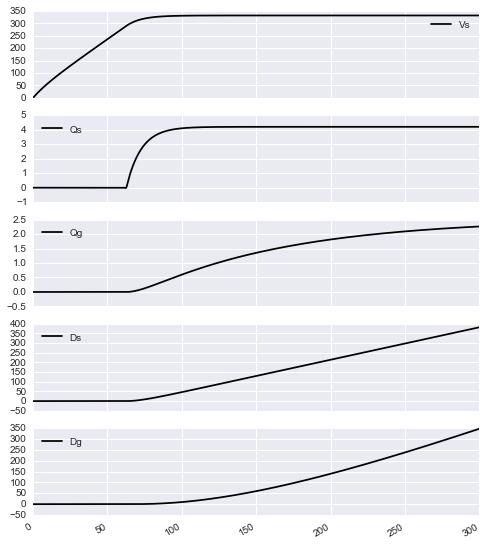

In [23]:
# SOLVE ODES WITH CONSTANT INPUT FLUXES OVER ONE TIME STEP

# Example model parameters
f_IExcess = 0.1 # Proportion of incoming rainfall that contributes to infiltration excess
alpha = 0.75    # PET correction factor (dimensionless)
beta = 0.6      # BFI (dimensionless)
T_s = 10.       # Soil residence time (days)
T_g = 100.      # Groundwater residence time (days)
fc = 290.       # Field capacity (mm)
step_len = 300  # Time step length (days)

# Example initial conditions
P = 8.         # Precipitation (mm/day)
E = 4.         # PET (mm/day)
Vs0 = 0.       # Initial soil volume (mm)
Vg0 = 0.       # Initial groundwater volume (mm)

# Calculate initial flows from initial volumes and time constants
Qs0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
Qg0 = Vg0/T_g

# Array of time points at which to evaluate ODEs
ti = np.linspace(0, step_len, 1000)

# Vector of initial conditions
y0 = [Vs0, Qs0, Qg0, 0., 0.]

# Model parameters
params=[P, E, f_IExcess, alpha, beta, T_s, T_g, fc]

# Solve
y = odeint(f, y0, ti, args=(params,))

# Build df from output
df = pd.DataFrame(data=y,
                  columns=['Vs', 'Qs', 'Qg', 'Ds', 'Dg'],
                  index=ti)
df.plot(subplots=True, figsize=(8, 10))
print df.tail()

In [67]:
def simple_hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ The hydrological model
    
            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [f_IExcess, alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        
            [Vs, Qs, Qg, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    f_IExcess, alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []
    output_rest = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'Rainfall_mm']
        E = input_df.ix[idx, 'PET_mm']
        
        # Calculate infiltration excess and add to results
        Qq = np.array(f_IExcess*P)
        output_rest.append(Qq)

        # Calculate Qs0 and Qg0 from Vs0 and Vg0
        Qs0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        Qg0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, Qs0, Qg0, 0., 0.]

        # Model parameters
        params=[P, E, f_IExcess, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(params,))

        # Extract values for end of step
        res = y[1]
        
        # Append quick flow infiltration excess values to results
        #np.hstack((res,Qq))

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_rest), columns=['Qq'],
                     index=input_df.index)
    
    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)
    
    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm_IE'] = df['Ds'] + df['Dg'] + df['Qq']
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = input_df['Runoff_mm']

    return df

                    Vs         S         G        Ds        Dg      Qq  \
Date                                                                     
2005-12-27  204.997953  0.992887  1.531609  0.390192  1.539508  0.0390   
2005-12-28  204.404426  0.870248  1.515511  0.371838  1.523639  0.0138   
2005-12-29  203.817434  0.747063  1.498460  0.322673  1.507064  0.0102   
2005-12-30  206.495409  1.297123  1.483951  0.413470  1.490728  0.1182   
2005-12-31  206.731856  1.344768  1.472532  0.528700  1.478186  0.0516   

            Sim_Runoff_mm_IE  Sim_Runoff_mm  Obs_Runoff_mm  
Date                                                        
2005-12-27          1.968700       1.929700       1.255725  
2005-12-28          1.909277       1.895477       1.206926  
2005-12-29          1.839937       1.829737       1.171998  
2005-12-30          2.022397       1.904197       1.195228  
2005-12-31          2.058486       2.006886       1.148435  


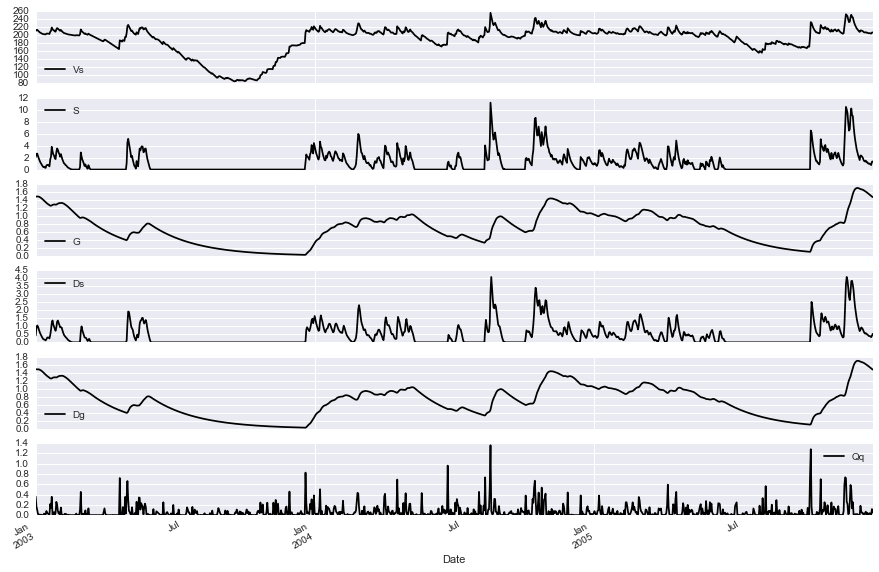

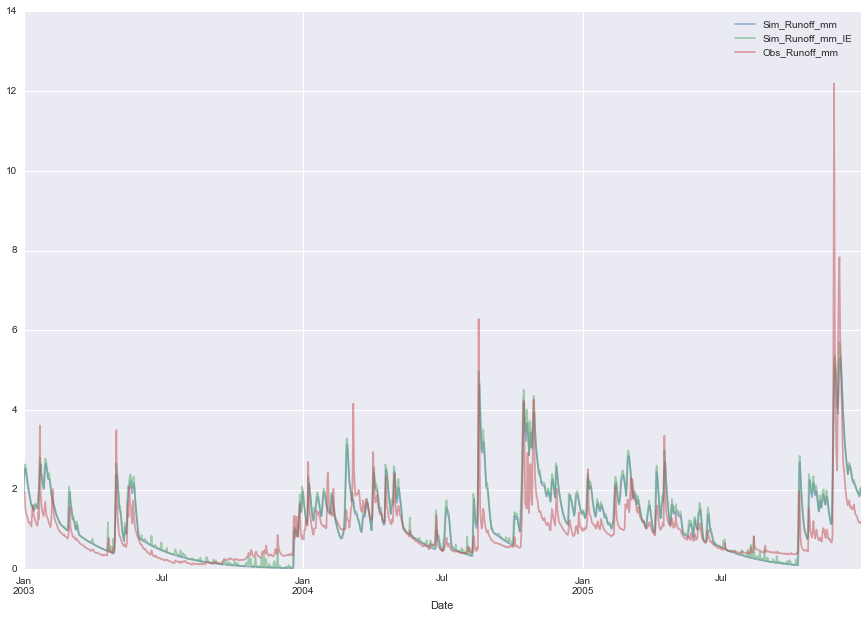

In [77]:
# RUN MODEL FOR A COUPLE OF YEARS

# Model setup
# Model parameters
f_IExcess = 0.03       # Proportion of incoming rainfall that contributes to infiltration excess
alpha = 0.7            # PET correction factor (dimensionless)
beta = 0.6            # BFI (dimensionless)
T_s = 5.             # Soil residence time (days)
T_g = 60.            # Groundwater residence time (days)
fc = 200              # Field capacity (mm) #SSKIB: 290
st_dt = '2003-01-01'  # Start date
end_dt = '2005-12-31' # End date

# Initial conditions
Vs0 = fc       # Initial soil volume (mm)
Vg0 = 90.       # Initial groundwater volume (mm)

# Run model
df = simple_hydro_model(met_df=met_df,
                        ics=[Vs0, Vg0],
                        mod_params=[f_IExcess, alpha, beta, T_s, T_g, fc],
                        period=[st_dt, end_dt])

# Discard burn-in
#df = df.truncate(before='2004-01-01')

print df.tail()

# Plot the simulated results
df[['Vs', 'S', 'G', 'Ds', 'Dg', 'Qq']].plot(subplots=True, 
                                      figsize=(15, 10))

df[['Sim_Runoff_mm', 'Sim_Runoff_mm_IE', 'Obs_Runoff_mm']].plot(alpha=0.5,
                                            figsize=(15, 10))